<a href="https://colab.research.google.com/github/annaiandresen/TDT4310-exercises/blob/master/BidirectionalLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/annaiandresen/TDT4310-exercises.git

Cloning into 'TDT4310-exercises'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 152 (delta 59), reused 125 (delta 32), pack-reused 0
Receiving objects: 100% (152/152), 27.71 MiB | 15.61 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install pickle5
!pip install pytorch
!pip install datasets
!pip install transformers

Training HF model using Google Colab

In [ ]:
!python TDT4310-exercises/project/main.py

Training Bidirectional LSTM using Tensorflow

In [5]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [6]:
# Load datasets
import pandas as pd

df = pd.read_csv("/content/gdrive/MyDrive/model/dataset.csv", usecols=['text', 'label']) 
df = df.sample(frac=1).reset_index(drop=True)
df = df.dropna()
df

,text,label
0,They are certainly better than some of the shi...,3
1,The answer was `` Ice hockey '' Sounds like so...,0
2,You're quite silly!,2
3,Yum.,2
4,This opinion is shared by almost everyone in m...,3
...,...,...
159995,Last time Europe really agreed to create one o...,2
159996,"What happened was bad for Germany, and it is a...",1
159997,"Bomb the rebels heavy weapons, send in a peace...",2
159998,"Otherwise politically and culturally, France i...",1


In [7]:
train, validate, test = np.split(df.sample(frac=1), [int(.6 * len(df)), int(.8 * len(df))])

x_train, y_train = train['text'].values, train['label'].values
x_test, y_test = test['text'].values, test['label'].values
x_val, y_val = test['text'].values, test['label'].values

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
x_val_tf = tf.convert_to_tensor(x_val)

x_val_tf

<tf.Tensor: shape=(31997,), dtype=string, numpy=
array([b'Both in Sweden and Finland, both countries I get to vote in.',
       b"There was a period where `` Norway '' didn't exist, but it had ended by the time Tordenskjold was alive.",
       b"I also think it's cultural.", ...,
       b"I have never heard that before, but `` brygge '' means something like dock in Norwegian, so that actually sounds likely.",
       b'He deserves to be forgotten.',
       b"They aren't necessarily factual, but based on facts."],
      dtype=object)>

In [8]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [9]:
# Text encoder
VOCAB_SIZE = 50000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize=None, ngrams=3)
encoder.adapt(x_train_tf)
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'is', 'that',
       'I', 'it', 'you', 'for', 'are', 'not', 'have', 'be', 'as', 'with'],
      dtype='<U27')

In [10]:
tf.debugging.set_log_device_placement(True)
tf.test.is_built_with_cuda()

True

In [11]:
encoded_example = encoder("This is an example")[:3].numpy()
encoded_example

array([118,   8,  53])

In [12]:
# Bidirectional with more layers
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
history = model.fit(x=x_train_tf, y=y_train, epochs=10,
                    validation_data=(x_val_tf, y_val),
                    validation_steps=30)

Epoch 1/10
3000/3000 [==============================] - 165s 49ms/step - loss: nan - accuracy: 0.2504 - val_loss: nan - val_accuracy: 0.2484
Epoch 2/10
3000/3000 [==============================] - 139s 46ms/step - loss: nan - accuracy: 0.2504 - val_loss: nan - val_accuracy: 0.2484
Epoch 3/10
3000/3000 [==============================] - 137s 46ms/step - loss: nan - accuracy: 0.2504 - val_loss: nan - val_accuracy: 0.2484
Epoch 4/10
3000/3000 [==============================] - 136s 45ms/step - loss: nan - accuracy: 0.2504 - val_loss: nan - val_accuracy: 0.2484
Epoch 5/10
3000/3000 [==============================] - 135s 45ms/step - loss: nan - accuracy: 0.2504 - val_loss: nan - val_accuracy: 0.2484
Epoch 6/10
3000/3000 [==============================] - 134s 45ms/step - loss: nan - accuracy: 0.2504 - val_loss: nan - val_accuracy: 0.2484
Epoch 7/10
3000/3000 [==============================] - 137s 46ms/step - loss: nan - accuracy: 0.2504 - val_loss: nan - val_accuracy: 0.2484
Epoch 8/10
30

In [13]:
test_loss, test_acc = model.evaluate(x_test_tf, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1000/1000 [==============================] - 17s 17ms/step - loss: nan - accuracy: 0.2484
Test Loss: nan
Test Accuracy: 0.248367041349411


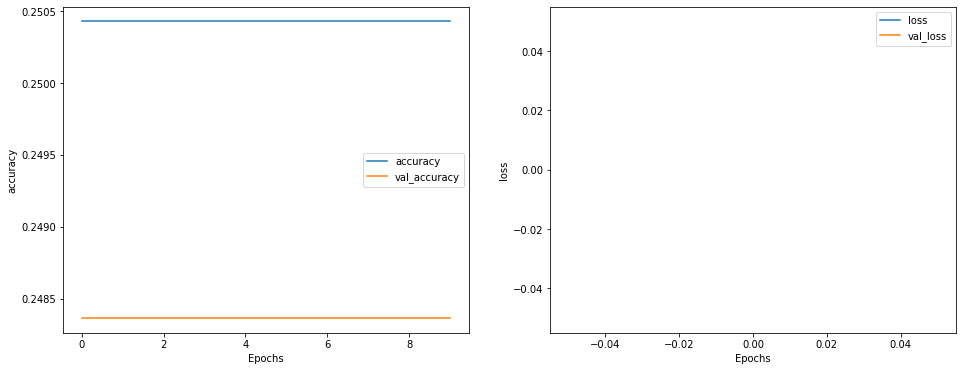

In [16]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')